In [1]:
!pip install sentence-transformers
!pip install faiss-gpu
!pip install pyngrok

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 67.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 37.4 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125926 sha256=299949527106fa29c71f8440384ff3c0f4440b13a34681e32ea35567b747da30
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!cp -r /content/drive/MyDrive/flickr30k_images /content

In [7]:
!mkdir static

In [5]:
!rm -rf "/content/static"

In [8]:
import os
import shutil

source_dir = '/content/flickr30k_images'
dest_dir = '/content/static'

for file_name in os.listdir(source_dir):
    if file_name.endswith('.jpg'):
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))


In [9]:
import pandas as pd
import time
from tqdm import tqdm
import seaborn as sns
import numpy as np
from textblob import TextBlob
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity


## News Dataset Model

In [10]:
# Create folder structure for Flask/ngrok
!mkdir templates

In [11]:
news_model = SentenceTransformer('msmarco-distilbert-base-v4')

In [13]:
df1 = pd.read_csv('/content/drive/MyDrive/data240/train.csv')
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Class Index  120000 non-null  int64 
 1   Title        120000 non-null  object
 2   Description  120000 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.7+ MB


In [14]:
df1 = df1[['Title','Description']]
df1.head()

,Title,Description
0,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [15]:
encoded_news_data = news_model.encode(df1['Description'].tolist())

In [16]:
def get_news_results(query):
    query_vector = news_model.encode(query)

    # Compute cosine similarities between query vector and encoded data
    similarities = cosine_similarity(query_vector.reshape(1, -1), encoded_news_data)

    # Rank encoded data based on cosine similarities
    results = [(i, similarity) for i, similarity in enumerate(similarities[0])]
    results = sorted(results, key=lambda x: x[1], reverse=True)

    # Format results
    top_k = 10
    formatted_results = []
    for i, similarity in results[:top_k]:
        title = df1.iloc[i]['Title']
        description = df1.iloc[i]['Description']
        formatted_results.append({'title': title, 'description': description, 'similarity': similarity})

    return formatted_results

In [17]:
from flask import Flask, render_template, request, send_file, url_for
import os
import requests
from io import BytesIO
from PIL import Image
import io
import shutil
from PIL import Image
from pyngrok import ngrok
app = Flask(__name__, template_folder="/content/templates")
from io import BytesIO

## **ADD ngrok auth token**

## Movie Plot

In [18]:
movie_model = SentenceTransformer('msmarco-distilbert-base-dot-prod-v3')

In [19]:
df2 = pd.read_csv('/content/drive/MyDrive/data240/wiki_movie_plots_deduped.csv',memory_map=True)
df2 = df2[['Title','Plot']]
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34886 entries, 0 to 34885
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Title   34886 non-null  object
 1   Plot    34886 non-null  object
dtypes: object(2)
memory usage: 545.2+ KB


In [20]:
import faiss
encoded_movie_data = movie_model.encode(df2.Plot.tolist())
encoded_movie_data = np.asarray(encoded_movie_data.astype('float32'))
movie_index = faiss.IndexIDMap(faiss.IndexFlatIP(768))
movie_index.add_with_ids(encoded_movie_data, np.array(range(0, len(df2))))
faiss.write_index(movie_index, 'movie_plot.index')

In [21]:
def fetch_movie_info(dataframe_idx):
    info = df2.iloc[dataframe_idx]
    meta_dict = {}
    meta_dict['Title'] = info['Title']
    meta_dict['Plot'] = info['Plot']
    return meta_dict

def search(query, top_k, index, model):
    t=time.time()
    query_vector = model.encode([query])
    top_k = index.search(query_vector, top_k)
    print('>>>> Results in Total Time: {}'.format(time.time()-t))
    top_k_ids = top_k[1].tolist()[0]
    top_k_ids = list(np.unique(top_k_ids))
    results =  [fetch_movie_info(idx) for idx in top_k_ids]
    return results

In [22]:
query="psycho thriller"
results=search(query, top_k=5, index=movie_index, model=movie_model)

results[0]

>>>> Results in Total Time: 0.05620527267456055


{'Title': 'The Dark Past',
 'Plot': "A psychoanalyst and his young family and some friends are taken hostage by a gang led by an escaped killer, Al Walker. The doctor gets the killer to talk to him in an attempt to find out the killer's unconscious motivation for his evil ways.\r\nWalker relates a dramatic dream he's been having since childhood. Eventually, his crimes are traced back to his childhood and lack of parental guidance, and by the end of the night the doctor has calmed the killer's murderous rage and prevented any further killings."}

In [23]:
def get_movies(query):
    results=search(query, top_k=5, index=movie_index, model=movie_model)
    return results

## Flickr Dataset

In [37]:
df3 = pd.read_csv('/content/drive/MyDrive/data240/combined_comments.csv')
df3.head()

,image_name,comment
0,1000092795.jpg,Two young guys with shaggy hair look at their...
1,10002456.jpg,Several men in hard hats are operating a gian...
2,1000268201.jpg,A child in a pink dress is climbing up a set ...
3,1000344755.jpg,Someone in a blue shirt and hat is standing o...
4,1000366164.jpg,"Two men , one in a gray shirt , one in a blac..."


<ipython-input-38-cdbdd837e06e>:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df3['doc_len'], hist=True, kde=True, color='b', label='doc len')


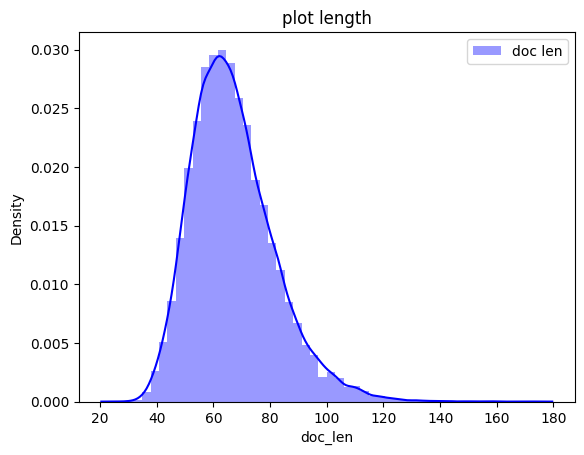

In [38]:
import pandas as pd
import time
from tqdm import tqdm
import seaborn as sns
import numpy as np
from textblob import TextBlob
import matplotlib.pyplot as plt
df3.dropna(inplace=True)
df3['doc_len'] = df3[' comment'].apply(lambda words: len(words.split()))
#max_seq_len = np.round(df3['doc_len'].mean() + df['doc_len'].std()).astype(int)
sns.distplot(df3['doc_len'], hist=True, kde=True, color='b', label='doc len')
#plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.title('plot length'); plt.legend()
plt.show()

In [39]:
image_model = SentenceTransformer('msmarco-distilbert-base-v4', device='cuda')
encoded_image_data = image_model.encode(df3[' comment'].tolist())

In [40]:
# # Encode user query
import PIL
query = 'car parked in middle of road'  # Replace with user input

query_vector = image_model.encode(query)

# Compute cosine similarities between query vector and encoded data
similarities = cosine_similarity(query_vector.reshape(1, -1), encoded_image_data)

# Rank encoded data based on cosine similarities
results = [(i, similarity) for i, similarity in enumerate(similarities[0])]
results = sorted(results, key=lambda x: x[1], reverse=True)

# Print top similar encoded data
top_k = 5
formatted_results = []
for i, similarity in results[:top_k]:
    title = df3.iloc[i]['image_name']
    img_path = "/content/static/3326024473.jpg"
    description = df3.iloc[i][' comment']
    formatted_results.append({'img_path': img_path, 'description': description})

formatted_results

[{'img_path': '/content/static/3326024473.jpg',
  'description': ' A Ford car is making a right turn as 3 males are walking across the street behind the car .,  A brown car is diving down the street , while people cross at the corner .,  Three boys in white shirts are walking behind an older model Ford car .,  An old Ford passes through the street .,  Old car driving down the road .'},
 {'img_path': '/content/static/3326024473.jpg',
  'description': ' a two-seated green sports car with the number 63 on its passenger side door on a driving track .,  A black antique race car with the number 63 is driving on a racetrack .,  A small green car with the number 63 on the door races on a track .,  A green sports car with the number 63 is driving on a track .,  A classic bottle-green Jaguar races around the track .'},
 {'img_path': '/content/static/3326024473.jpg',
  'description': ' A silver and blue rally car is passing two spectators who are standing at the roadside .,  A race car , numbered

In [41]:
def get_images(query):
    query_vector = image_model.encode(query)

    # Compute cosine similarities between query vector and encoded data
    similarities = cosine_similarity(query_vector.reshape(1, -1), encoded_image_data)

    # Rank encoded data based on cosine similarities
    results = [(i, similarity) for i, similarity in enumerate(similarities[0])]
    results = sorted(results, key=lambda x: x[1], reverse=True)

    # Print top similar encoded data
    top_k = 5
    formatted_results = []
    for i, similarity in results[:top_k]:
        title = str(df3.iloc[i]['image_name'])
        img_path = '/content/static/' + title
        description = df3.iloc[i][' comment']
        formatted_results.append({'title': title, 'img_path': img_path, 'description': description})

    return formatted_results

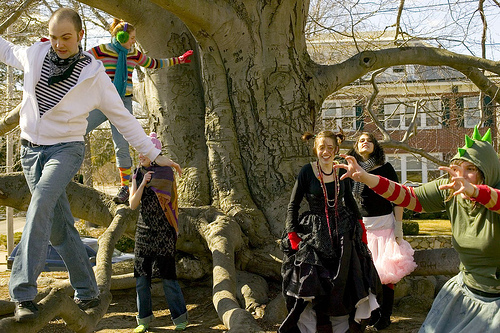

In [42]:
PIL.Image.open("/content/static/114474325.jpg")

## Stack Data

In [44]:
combined_dataset = pd.read_csv("/content/drive/MyDrive/data240/stack.csv")
combined_dataset.head(10)

,Title,Plot
0,Kansas Saloon Smashers,"A bartender is working at a saloon, serving dr..."
1,Love by the Light of the Moon,"The moon, painted with a smiling face hangs ov..."
2,The Martyred Presidents,"The film, just over a minute long, is composed..."
3,"Terrible Teddy, the Grizzly King",Lasting just 61 seconds and consisting of two ...
4,Jack and the Beanstalk,The earliest known adaptation of the classic f...
5,Alice in Wonderland,"Alice follows a large white rabbit down a ""Rab..."
6,The Great Train Robbery,The film opens with two bandits breaking into ...
7,The Suburbanite,The film is about a family who move to the sub...
8,The Little Train Robbery,The opening scene shows the interior of the ro...
9,The Night Before Christmas,Scenes are introduced using lines of the poem....


In [46]:
stack_model = SentenceTransformer('msmarco-distilbert-base-dot-prod-v3', device='cuda')
encoded_data_st = stack_model.encode(combined_dataset.Plot.tolist())
encoded_data_st = np.asarray(encoded_data_st.astype('float32'))
index_st = faiss.IndexIDMap(faiss.IndexFlatIP(768))
index_st.add_with_ids(encoded_data_st, np.array(range(0, len(combined_dataset))))
faiss.write_index(index_st, 'stack_plot.index')

In [47]:
def fetch_stack_info(dataframe_idx):
    info = combined_dataset.iloc[dataframe_idx]
    meta_dict = dict()
    meta_dict['Title'] = info['Title']
    meta_dict['Plot'] = info['Plot'][:500]
    return meta_dict
    
def search_stack(query, top_k, index, model):
    t=time.time()
    query_vector = model.encode([query])
    top_k = index.search(query_vector, top_k)
    print('>>>> Results in Total Time: {}'.format(time.time()-t))
    top_k_ids = top_k[1].tolist()[0]
    top_k_ids = list(np.unique(top_k_ids))
    results =  [fetch_stack_info(idx) for idx in top_k_ids]
    return results

In [48]:
import time
query="ae analysis definition; Part I describes an intelligent acoustic emission locator, while Part II"
results=search_stack(query, top_k=5, index=index_st, model=stack_model)
results

>>>> Results in Total Time: 0.11801815032958984


[{'Title': 'Intelligent location of simultaneously active acoustic emission sources:\n  Part I',
  'Plot': '  The intelligent acoustic emission locator is described in Part I, while Part\nII discusses blind source separation, time delay estimation and location of two\nsimultaneously active continuous acoustic emission sources.\n  The location of acoustic emission on complicated aircraft frame structures is\na difficult problem of non-destructive testing. This article describes an\nintelligent acoustic emission source locator. The intelligent locator comprises\na sensor antenna and a general regression neura'},
 {'Title': 'Intelligent location of simultaneously active acoustic emission sources:\n  Part II',
  'Plot': '  Part I describes an intelligent acoustic emission locator, while Part II\ndiscusses blind source separation, time delay estimation and location of two\ncontinuous acoustic emission sources.\n  Acoustic emission (AE) analysis is used for characterization and location of\n

In [49]:
def get_stack(query):
  results=search_stack(query, top_k=5, index=index_st, model=stack_model)
  return results

In [50]:
!ngrok config add-authtoken 2PTLCPCfsCRzm6bfmuWjdPLkYCV_5K8VJmek42bhduHcWkHUf

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [56]:
from flask import Flask, render_template, request
from pyngrok import ngrok

app = Flask(__name__)

@app.route('/', methods=['GET', 'POST'])
def home():
    processed_result1 = None
    processed_result2 = None
    processed_result3 = None
    processed_result4 = None
    path = None
    imgg = None

    if request.method == 'POST':
        if 'news_input' in request.form:
            news_input = request.form['news_input']
            processed_result1 = get_news_results(news_input)

        if 'movie_input' in request.form:
            movie_input = request.form['movie_input']
            processed_result2 = get_movies(movie_input)

        if 'img_input' in request.form:
            img_input = request.form['img_input']
            processed_result3 = get_images(img_input)

        if 'stk_input' in request.form:
            stk_input = request.form['stk_input']
            processed_result4 = get_stack(stk_input)

    return render_template('index.html', stack = processed_result4, news=processed_result1, movies=processed_result2, images=processed_result3)


if __name__ == "__main__":
    ngrok_tunnel = ngrok.connect(5000)
    print('Flask app running at:', ngrok_tunnel.public_url)
    app.run() 

Flask app running at: https://673b-35-204-246-225.ngrok-free.app
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [19/May/2023 05:31:36] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/May/2023 05:31:36] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [19/May/2023 05:31:46] "POST / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/May/2023 05:32:00] "POST / HTTP/1.1" 200 -


>>>> Results in Total Time: 0.05062508583068848


INFO:werkzeug:127.0.0.1 - - [19/May/2023 05:32:13] "POST / HTTP/1.1" 200 -


>>>> Results in Total Time: 0.12140512466430664


INFO:werkzeug:127.0.0.1 - - [19/May/2023 05:44:33] "GET / HTTP/1.1" 200 -
